In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import os

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
directory_path = r'/home/ryan/Documents/CBI/nesscan_fixed_removed_flat_lines_03312025/bobHallPier'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp[bhp['date'] <= pd.to_datetime('2008-01-01')]
bhp = bhp.reset_index(drop=True)

bhp

,date,pwl
0,1996-01-01 00:00:00,6.800
1,1996-01-01 00:06:00,6.773
2,1996-01-01 00:12:00,6.806
3,1996-01-01 00:18:00,6.833
4,1996-01-01 00:24:00,6.869
...,...,...
1051916,2007-12-31 23:36:00,6.708
1051917,2007-12-31 23:42:00,6.723
1051918,2007-12-31 23:48:00,6.717
1051919,2007-12-31 23:54:00,6.723


In [35]:
pc = pd.read_csv('/home/ryan/Downloads/pd_1747414029.csv')
pc['date'] = pd.to_datetime(pc['#date+time'],errors='coerce')
pc = pc.drop(columns=['#date+time'])
pc = pc.drop(pc.index[-2:])
pc

/tmp/ipykernel_6275/1465235489.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pc = pd.read_csv('/home/ryan/Downloads/pd_1747414029.csv')


,005-pwl,date
0,0.910,1996-01-01 00:00:00
1,0.911,1996-01-01 00:06:00
2,0.913,1996-01-01 00:12:00
3,0.914,1996-01-01 00:18:00
4,0.916,1996-01-01 00:24:00
...,...,...
1052155,0.947,2008-01-01 23:30:00
1052156,0.945,2008-01-01 23:36:00
1052157,0.946,2008-01-01 23:42:00
1052158,0.945,2008-01-01 23:48:00


In [36]:
main = bhp.merge(pc, on='date', how='inner')
main['source'] = pd.to_numeric(main['005-pwl'], errors='coerce')

In [37]:
invalid = main['source'].isna() | main['pwl'].isna()
segment_id = (~invalid).astype(int).groupby((invalid != invalid.shift()).cumsum()).cumsum()
main['segment'] = segment_id.where(~invalid, np.nan)

In [52]:
X, y = [], []

for seg_id, group in main.groupby("segment"):
    if pd.isna(seg_id) or len(group) < 11:
        continue
    
    group = group.reset_index(drop=True)
    
    for i in range(len(group) - 10):
        source_window = group['source'].iloc[i:i+10].values
        target_window = group['pwl'].iloc[i:i+10].values
        target_value = group['pwl'].iloc[i+10]
        
        if not (np.isnan(source_window).any() or np.isnan(target_window).any() or np.isnan(target_value)):
            X.append(np.concatenate([source_window, target_window]))  # 20 features
            y.append(target_value)

X = np.array(X)
y = np.array(y)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(20,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Linear output for regression
])

In [55]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [56]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=512)

Epoch 1/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.6355 - mae: 2.1424 - val_loss: 0.1839 - val_mae: 0.3255
Epoch 2/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1295 - mae: 0.2691 - val_loss: 0.0742 - val_mae: 0.2031
Epoch 3/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0721 - mae: 0.1968 - val_loss: 0.0611 - val_mae: 0.1822
Epoch 4/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0612 - mae: 0.1811 - val_loss: 0.0570 - val_mae: 0.1745
Epoch 5/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0583 - mae: 0.1751 - val_loss: 0.0547 - val_mae: 0.1720
Epoch 6/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0572 - mae: 0.1719 - val_loss: 0.0529 - val_mae: 0.1687
Epoch 7/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0547 - mae: 0.1688 - val_loss: 0.0518 - val_mae: 0.1651
Epoch 8/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0522 - mae: 0.1654 - val_loss: 0.0504 - val_mae: 0.1630
Epoch 9/50
908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [57]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.3f}")
y_pred = model.predict(X_test)


4538/4538 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0391 - mae: 0.1434
Test MAE: 0.144
4538/4538 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


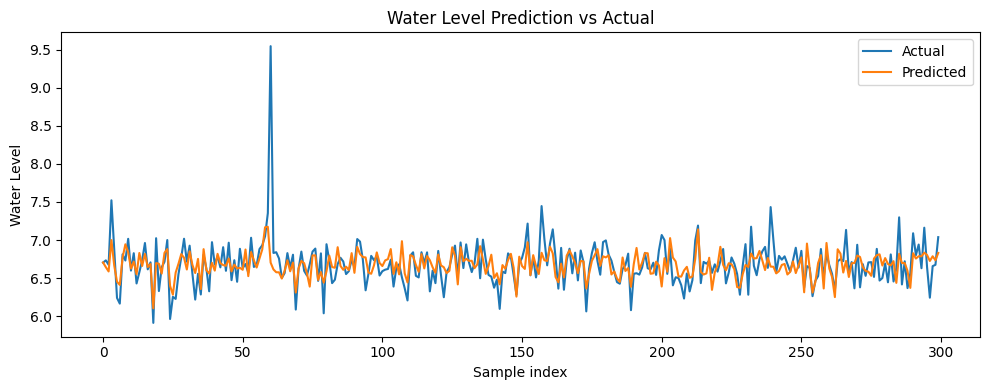

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred[:300], label='Predicted')
plt.legend()
plt.title("Water Level Prediction vs Actual")
plt.xlabel("Sample index")
plt.ylabel("Water Level")
plt.tight_layout()
plt.show()


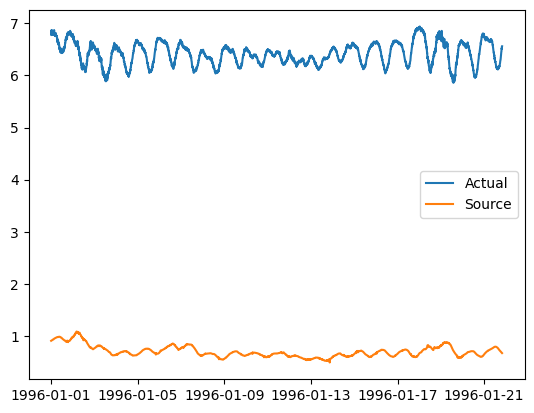

In [51]:
plt.plot(main['date'][0:5000], main['pwl'][0:5000], label='Actual')
plt.plot(main['date'][0:5000], main['source'][0:5000], label='Source')
plt.legend()